In [1]:
import sys
sys.path.append('/home/prasse/work/Projekte/AEye/reading-comprehension/')
from rf_baseline  import rf_feature_extraction as rf_feature_extraction
import datetime
from typing import Tuple
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import json
import random
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import Variable
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.math import l2_normalize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Embedding, Average, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [15]:
def get_nn_model(ent_len,num_ent,
                 pos_len,num_pos,
                 red_pos_len, num_red_pos,
                 con_len, num_con,
                 num_features,
                 fix_len = None, num_fix = None,
                 flag_sequence_bilstm = False):
    
    drop_outs = 0.3
    concat_list = []
    input_list  = []
    
    if ent_len is not None:   
        x_ent_input = Input(shape=ent_len)
        x_ent = Embedding(input_dim = num_ent,
                            output_dim = 64)(x_ent_input)
        if flag_sequence_bilstm:
            x_ent = Bidirectional(LSTM(25, return_sequences = True))(x_ent)
            x_ent = Bidirectional(LSTM(25))(x_ent)
            x_ent = Dropout(0.3)(x_ent)
            x_ent = Dense(50,activation='relu')(x_ent)
            x_ent = Dropout(0.3)(x_ent)
            x_ent = Dense(20,activation = 'relu')(x_ent) 
        else:
            x_ent_avg = GlobalAveragePooling1D()(x_ent)
            x_ent_max = GlobalMaxPool1D()(x_ent)
            x_ent = Concatenate()([x_ent_avg,x_ent_max])
            x_ent = Dense(64,activation='relu')(x_ent)
            x_ent = Dense(32,activation='relu')(x_ent)
        concat_list.append(x_ent)
        input_list.append(x_ent_input)
    
    if pos_len is not None:    
        x_pos_input = Input(shape=pos_len)
        x_pos = Embedding(input_dim = num_pos,
                            output_dim = 128)(x_pos_input)
        if flag_sequence_bilstm:
            x_pos = Bidirectional(LSTM(25, return_sequences = True))(x_pos)
            x_pos = Bidirectional(LSTM(25))(x_pos)
            x_pos = Dropout(0.3)(x_pos)
            x_pos = Dense(50,activation='relu')(x_pos)
            x_pos = Dropout(0.3)(x_pos)
            x_pos = Dense(20,activation = 'relu')(x_pos)
        else:
            x_pos_avg = GlobalAveragePooling1D()(x_pos)
            x_pos_max = GlobalMaxPool1D()(x_pos)
            x_pos = Concatenate()([x_pos_avg,x_pos_max])
            x_pos = Dense(128,activation='relu')(x_pos)
            x_pos = Dense(64,activation='relu')(x_pos)
            x_pos = Dense(32,activation='relu')(x_pos)
        concat_list.append(x_pos)
        input_list.append(x_pos_input)
    
    if red_pos_len is not None:
        x_red_pos_input = Input(shape=red_pos_len)
        x_red_pos = Embedding(input_dim = num_red_pos,
                            output_dim = 8)(x_red_pos_input)
        if flag_sequence_bilstm:
            x_red_pos = Bidirectional(LSTM(25, return_sequences = True))(x_red_pos)
            x_red_pos = Bidirectional(LSTM(25))(x_red_pos)
            x_red_pos = Dropout(0.3)(x_red_pos)
            x_red_pos = Dense(50,activation='relu')(x_red_pos)
            x_red_pos = Dropout(0.3)(x_red_pos)
            x_red_pos = Dense(20,activation = 'relu')(x_red_pos)
        else:
            x_red_pos_avg = GlobalAveragePooling1D()(x_red_pos)
            x_red_pos_max = GlobalMaxPool1D()(x_red_pos)
            x_red_pos = Concatenate()([x_red_pos_avg,x_red_pos_max])
            x_red_pos = Dense(128,activation='relu')(x_pos)
            x_red_pos = Dense(64,activation='relu')(x_pos)
            x_red_pos = Dense(32,activation='relu')(x_pos)
        concat_list.append(x_red_pos)
        input_list.append(x_red_pos_input)
        
    if con_len is not None:    
        x_con_input = Input(shape=con_len)
        x_con = Embedding(input_dim = num_con,
                            output_dim = 8)(x_con_input)
        if flag_sequence_bilstm:
            x_con = Bidirectional(LSTM(25, return_sequences = True))(x_con)
            x_con = Bidirectional(LSTM(25))(x_con)
            x_con = Dropout(0.3)(x_con)
            x_con = Dense(50,activation='relu')(x_con)
            x_con = Dropout(0.3)(x_con)
            x_con = Dense(20,activation = 'relu')(x_con)
        else:
            x_con_avg = GlobalAveragePooling1D()(x_con)
            x_con_max = GlobalMaxPool1D()(x_con)
            x_con = Concatenate()([x_con_avg,x_con_max])
            x_con = Dense(128,activation='relu')(x_con)
            x_con = Dense(64,activation='relu')(x_con)
            x_con = Dense(32,activation='relu')(x_con)
        concat_list.append(x_con)
        input_list.append(x_con_input)
    
    if num_features is not None:
        x_num_input = Input(shape=num_features)
        #x_num = Dense(256,activation='relu')(x_num_input)
        #x_num = Dropout(drop_outs)(x_num)
        #x_num = Dense(128,activation='relu')(x_num)
        #x_num = Dropout(drop_outs)(x_num)
        #x_num = Dense(64,activation='relu')(x_num)
        x_num = Dropout(drop_outs)(x_num_input)
        x_num = Dense(32,activation='relu')(x_num)
        concat_list.append(x_num)
        input_list.append(x_num_input)
        
    if fix_len is not None:
        x_fix_input = Input(shape=(fix_len,num_fix))
        x_fix = Bidirectional(LSTM(25, return_sequences = True),input_shape=input_shape)(x_fix_input)
        x_fix = Bidirectional(LSTM(25))(x_fix)
        x_fix = Dropout(0.3)(x_fix)
        x_fix = Dense(50,activation='relu')(x_fix)
        x_fix = Dropout(0.3)(x_fix)
        x_fix = Dense(20,activation = 'relu')(x_fix)        
        concat_list.append(x_fix)
        input_list.append(x_fix_input)
    
    x_concat = Concatenate()(concat_list)
    x_output = Dense(32,activation='relu')(x_concat)
    x_output = Dense(1,activation='sigmoid')(x_output)
    model = Model(input_list,
                outputs=x_output)
    opt = Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
    #model.summary()
    return model

In [3]:
GPU = 2
# select graphic card
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config = tf.compat.v1.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
tf_session = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0



In [4]:
def help_roc_auc(y_true,y_pred):
    if len(np.unique(y_true)) == 1:
        return .5
    else:
        return roc_auc_score(y_true,y_pred)

# calculate the roc-auc as a metric
def auroc(y_true, y_pred):
    return tf.py_function(help_roc_auc, (y_true, y_pred), tf.double)

In [34]:
def train_nn(spit_criterions,labels,
            feature_string,feature_names_per_word,
            model_name,input_window,
            flag_sequence_bilstm = True,
            word_in_fixation_order = True,
            use_pos_sequence = True,
            use_reduced_pos_sequence = True,
            use_entity_sequence = True,
            use_content_word_sequence = True,
            use_numeric = True,
            use_fixation_sequence = True,
            flag_redo = False):
    for split_criterion in spit_criterions:
        for label in labels:
            model_prefix = str(flag_sequence_bilstm) +\
                '_' + str(word_in_fixation_order) +\
            '_' + str(use_pos_sequence) +\
            '_' + str(use_reduced_pos_sequence) +\
            '_' + str(use_entity_sequence) +\
            '_' + str(use_content_word_sequence) +\
            '_' + str(use_numeric) +\
            '_' + str(use_fixation_sequence) +\
            '_'
            save_path=f'/home/prasse/work/Projekte/AEye/reading-comprehension/rf_baseline/results/{model_prefix}{model_name}_{split_criterion}_text_sequence_{label}_{input_window}.csv'
            if not flag_redo and os.path.exists(save_path):
                continue
            SB_SAT_PATH = f'/raid/projects/reich3/reading-comprehension/paper_splits/{input_window}/{split_criterion}/'
            split_criterion_dict = {
                'subj': 0,
                'book': 1,
            }
            with open('/raid/projects/reich3/reading-comprehension/npy_files/labels_dict.json') as fp:
                label_dict = json.load(fp)

            if split_criterion == 'book':
                num_folds = 4
            else:
                num_folds = 5
            pd_init = pd.DataFrame(
                columns=[
                    'ahn_baseline',
                    'fold0_auc', 'fold1_auc', 'fold2_auc', 'fold3_auc', 'fold4_auc',
                    'fold0_tpr', 'fold1_tpr', 'fold2_tpr', 'fold3_tpr', 'fold4_tpr',
                    'fold0_fpr', 'fold1_fpr', 'fold2_fpr', 'fold3_fpr', 'fold4_fpr',
                    'fold0_y_pred', 'fold1_y_pred', 'fold2_y_pred', 'fold3_y_pred', 'fold4_y_pred',
                    'fold0_y_test', 'fold1_y_test', 'fold2_y_test', 'fold3_y_test', 'fold4_y_test',
                'avg_auc', 'std_auc']
            )
            pd_init['ahn_baseline'] = [model_name]

            if input_window == 'window':
                input_shape = (21, )
            elif input_window == 'page':
                input_shape = (150, 11)


            for fold in range(num_folds):
                np.random.seed(fold)
                random.seed(fold)
                # collect the inputs for train, validation and test
                # use only features where flag is True
                train_inputs = []
                val_inputs   = []
                test_inputs  = []
                X_train_path = os.path.join(SB_SAT_PATH, f'X_train_{split_criterion}{feature_string}{fold}.npy')
                X_train_fix_path = os.path.join(SB_SAT_PATH, f'X_train_{split_criterion}{feature_string}{fold}_fix_data.npy')
                y_train_path = os.path.join(SB_SAT_PATH, f'y_train_{split_criterion}{feature_string}{fold}.npy')
                x_train_all, y_train_all = np.load(X_train_path), np.load(y_train_path, allow_pickle=True)
                x_train_fix_all = np.load(X_train_fix_path)
                x_train_fix_postions  = x_train_fix_all[:,:,4]
                if normalize_flag:
                    scaler = MinMaxScaler()
                    fix_scaler = MinMaxScaler()
                    x_train_all = scaler.fit_transform(x_train_all.reshape(-1, x_train_all.shape[-1])).reshape(x_train_all.shape)
                    x_train_fix_all = fix_scaler.fit_transform(x_train_fix_all.reshape(-1, x_train_fix_all.shape[-1])).reshape(x_train_fix_all.shape)
                    x_train_fix_all = np.where(np.isnan(x_train_fix_all), -4, x_train_fix_all)
                if split_criterion != 'book':
                    outer_cv = KFold(n_splits=4, shuffle=True, random_state=fold)
                else:
                    outer_cv = KFold(n_splits=3, shuffle=True, random_state=fold)

                if split_criterion != 'book-page':
                    splitkeys = np.array(sorted(list(set(y_train_all[:, split_criterion_dict[split_criterion]]))))
                else:
                    splitkeys = y_train_all[:, label_dict[label]]

                for train_idx, val_idx in outer_cv.split(splitkeys):
                    break

                if split_criterion != 'book-page':
                    N_train_sub = splitkeys[train_idx]
                    N_test_sub = splitkeys[val_idx]

                    train_idx = np.where(np.isin(y_train_all[:, split_criterion_dict[split_criterion]], N_train_sub))[0]
                    val_idx = np.where(np.isin(y_train_all[:, split_criterion_dict[split_criterion]], N_test_sub))[0]
                x_train = x_train_all[train_idx]
                y_train = y_train_all[train_idx]
                x_val = x_train_all[val_idx]
                y_val = y_train_all[val_idx]
                y_train_all[val_idx]    

                y_train = np.array(y_train[:, label_dict[label]], dtype=int)
                y_val = np.array(y_val[:, label_dict[label]], dtype=int)

                x_train, feature_names = rf_feature_extraction.get_rf_features_for_word_features(
                            x_train,feature_names_per_word,disable = False,
                            use_gaze_entropy_features = use_gaze_entropy_features)
                x_val, _ = rf_feature_extraction.get_rf_features_for_word_features(
                            x_val,feature_names_per_word,disable = False,
                            use_gaze_entropy_features = use_gaze_entropy_features)


                # Test Data
                X_test_path = os.path.join(SB_SAT_PATH, f'X_test_{split_criterion}{feature_string}{fold}.npy')
                X_test_fix_path = os.path.join(SB_SAT_PATH, f'X_test_{split_criterion}{feature_string}{fold}_fix_data.npy')
                y_test_path = os.path.join(SB_SAT_PATH, f'y_test_{split_criterion}{feature_string}{fold}.npy')
                x_test_all, y_test_all = np.load(X_test_path), np.load(y_test_path, allow_pickle=True)
                x_test_fix_all = np.load(X_test_fix_path)
                x_test_fix_postions  = x_test_fix_all[:,:,4]
                if normalize_flag:
                    x_test_all = scaler.transform(x_test_all.reshape(-1, x_test_all.shape[-1])).reshape(x_test_all.shape)
                    x_test_fix_all = fix_scaler.transform(x_test_fix_all.reshape(-1, x_test_fix_all.shape[-1])).reshape(x_test_fix_all.shape)
                    x_test_fix_all = np.where(np.isnan(x_test_fix_all), -4, x_test_fix_all)                
                y_test = np.array(y_test_all[:, label_dict[label]], dtype=int)


                x_test, _ = rf_feature_extraction.get_rf_features_for_word_features(
                            x_test_all,feature_names_per_word,disable = False,
                            use_gaze_entropy_features = use_gaze_entropy_features)


                # POS + Entity Lists + reduced POS + content word lists
                pos_list_list_train, entity_list_list_train, reduced_pos_list_list_train, content_list_list_train, pos_feature_names, entity_feature_names, reduced_pos_feature_names, content_word_feature_names, fix_position_ind_train = rf_feature_extraction.get_watched_pos_entity_lists(
                        x_train_all,feature_names_per_word,x_train_fix_postions)
                pos_list_list_test, entity_list_list_test, reduced_pos_list_list_test, content_list_list_test, _, _, _, _, fix_position_ind_test = rf_feature_extraction.get_watched_pos_entity_lists(
                        x_test_all,feature_names_per_word,x_test_fix_postions)


                pos_lens     = [len(pos_list) for pos_list in pos_list_list_train]
                fix_lens     = [len(pos_fix_list) for pos_fix_list in fix_position_ind_train]
                entity_lens  = [len(ent_list) for ent_list in entity_list_list_train]
                max_pos_len  = np.max(pos_lens)
                max_ent_len  = np.max(entity_lens)
                max_fix_len  = np.max(fix_lens)


                # POS
                train_pos_matrix, pos_mapping_dict = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                pos_list_list_train,pos_feature_names,max_pos_len)
                test_pos_matrix, _ = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                pos_list_list_test,pos_feature_names,max_pos_len,pos_mapping_dict)
                train_pos_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                pos_list_list_train,pos_feature_names,max_fix_len,
                                pos_mapping_dict, fix_position_ind_train)
                test_pos_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                pos_list_list_test,pos_feature_names,max_fix_len,
                                pos_mapping_dict, fix_position_ind_test)

                # Entity
                train_ent_matrix, ent_mapping_dict = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                entity_list_list_train,entity_feature_names,max_ent_len)
                test_ent_matrix, _ = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                entity_list_list_test,entity_feature_names,max_ent_len,ent_mapping_dict)
                train_ent_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                entity_list_list_train,entity_feature_names,max_fix_len,
                                ent_mapping_dict, fix_position_ind_train)
                test_ent_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                entity_list_list_test,entity_feature_names,max_fix_len,
                                ent_mapping_dict, fix_position_ind_test)

                # Reduced POS
                train_reduced_pos_matrix, reduced_pos_mapping_dict = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                reduced_pos_list_list_train, reduced_pos_feature_names, max_pos_len)
                test_reduced_pos_matrix, _ = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                reduced_pos_list_list_test,reduced_pos_feature_names,max_pos_len,reduced_pos_mapping_dict)
                train_reduced_pos_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                reduced_pos_list_list_train,reduced_pos_feature_names,max_fix_len,
                                reduced_pos_mapping_dict, fix_position_ind_train)
                test_reduced_pos_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                reduced_pos_list_list_test,reduced_pos_feature_names,max_fix_len,
                                reduced_pos_mapping_dict, fix_position_ind_test)

                # Content Words
                train_content_matrix, content_word_mapping_dict = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                content_list_list_train, content_word_feature_names, max_pos_len)
                test_content_matrix, _ = rf_feature_extraction.convert_to_sequence_to_nn_input(
                                content_list_list_test,content_word_feature_names,max_pos_len,content_word_mapping_dict)
                train_content_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                content_list_list_train,content_word_feature_names,max_fix_len,
                                content_word_mapping_dict, fix_position_ind_train)
                test_content_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                                content_list_list_test,content_word_feature_names,max_fix_len,
                                content_word_mapping_dict, fix_position_ind_test)

                num_pos          = len(pos_mapping_dict) + 1
                num_ent          = len(ent_mapping_dict) + 1
                num_reduced_pos  = len(reduced_pos_mapping_dict) + 1
                num_content_word = len(content_word_mapping_dict) + 1


                val_pos_fix_matrix   = train_pos_fix_matrix[val_idx]
                train_pos_fix_matrix = train_pos_fix_matrix[train_idx]
                test_pos_fix_matrix  = test_pos_fix_matrix

                val_ent_fix_matrix   = train_ent_fix_matrix[val_idx]
                train_ent_fix_matrix = train_ent_fix_matrix[train_idx]
                test_ent_fix_matrix  = test_ent_fix_matrix

                val_reduced_pos_fix_matrix   = train_reduced_pos_fix_matrix[val_idx]
                train_reduced_pos_fix_matrix = train_reduced_pos_fix_matrix[train_idx]
                test_reduced_pos_fix_matrix  = test_reduced_pos_fix_matrix

                val_content_fix_matrix       = train_content_fix_matrix[val_idx]
                train_content_fix_matrix     = train_content_fix_matrix[train_idx]
                test_content_fix_matrix      = test_content_fix_matrix

                val_pos_matrix   = train_pos_matrix[val_idx]
                train_pos_matrix = train_pos_matrix[train_idx]
                test_pos_matrix  = test_pos_matrix

                val_ent_matrix   = train_ent_matrix[val_idx]
                train_ent_matrix = train_ent_matrix[train_idx]
                test_ent_matrix  = test_ent_matrix

                val_reduced_pos_matrix   = train_reduced_pos_matrix[val_idx]
                train_reduced_pos_matrix = train_reduced_pos_matrix[train_idx]
                test_reduced_pos_matrix  = test_reduced_pos_matrix

                val_content_matrix       = train_content_matrix[val_idx]
                train_content_matrix     = train_content_matrix[train_idx]
                test_content_matrix      = test_content_matrix


                train_fix_matrix   = x_train_fix_all[:,:,:-1]
                val_fix_matrix     = train_fix_matrix[val_idx]
                train_fix_matrix   = train_fix_matrix[train_idx]
                test_fix_matrix    = x_test_fix_all[:,:,:-1]

                ent_len         = train_ent_matrix.shape[1]
                pos_len         = train_pos_matrix.shape[1]
                reduced_pos_len = train_reduced_pos_matrix.shape[1]
                content_len     = train_content_matrix.shape[1]
                num_features    = x_train.shape[1]
                num_fix         = train_fix_matrix.shape[2]
                fix_len         = train_fix_matrix.shape[1]

                # scale the RF input
                rf_input_scaler = MinMaxScaler()
                x_train         = rf_input_scaler.fit_transform(x_train)
                x_val           = rf_input_scaler.transform(x_val)
                x_test          = rf_input_scaler.transform(x_test)
                
                
                # create input lists
                if use_entity_sequence:
                    if word_in_fixation_order:
                        train_inputs.append(train_ent_fix_matrix)
                        val_inputs.append(val_ent_fix_matrix)
                        test_inputs.append(test_ent_fix_matrix)
                        ent_len = train_ent_fix_matrix.shape[1]
                        num_ent = len(ent_mapping_dict) + 1
                    else:
                        train_inputs.append(train_ent_matrix)
                        val_inputs.append(val_ent_matrix)
                        test_inputs.append(test_ent_matrix)
                        ent_len = train_ent_matrix.shape[1]
                        num_ent = len(ent_mapping_dict) + 1
                else:
                    ent_len = None
                    num_ent = None
                        
                if use_pos_sequence:
                    if word_in_fixation_order:
                        train_inputs.append(train_pos_fix_matrix)
                        val_inputs.append(val_pos_fix_matrix)
                        test_inputs.append(test_pos_fix_matrix)
                        pos_len = train_pos_fix_matrix.shape[1]
                        num_pos = len(pos_mapping_dict) + 1
                    else:
                        train_inputs.append(train_pos_matrix)
                        val_inputs.append(val_pos_matrix)
                        test_inputs.append(test_pos_matrix)
                        pos_len = train_pos_matrix.shape[1]
                        num_pos = len(pos_mapping_dict) + 1
                else:
                    pos_len = None
                    num_pos = None
                
                if use_reduced_pos_sequence:
                    if word_in_fixation_order:
                        train_inputs.append(train_reduced_pos_fix_matrix)
                        val_inputs.append(val_reduced_pos_fix_matrix)
                        test_inputs.append(test_reduced_pos_fix_matrix)
                        reduced_pos_len = train_reduced_pos_fix_matrix.shape[1]
                        num_pos_reduced = len(reduced_pos_mapping_dict) + 1
                    else:
                        train_inputs.append(train_reduced_pos_matrix)
                        val_inputs.append(val_reduced_pos_matrix)
                        test_inputs.append(test_reduced_pos_matrix)
                        reduced_pos_len = train_reduced_pos_matrix.shape[1]
                        num_pos_reduced = len(reduced_pos_mapping_dict) + 1
                else:
                    reduced_pos_len = None
                    num_pos_reduced = None
                
                if use_content_word_sequence:
                    if word_in_fixation_order:
                        train_inputs.append(train_content_fix_matrix)
                        val_inputs.append(val_content_fix_matrix)
                        test_inputs.append(test_content_fix_matrix)
                        content_len = train_content_fix_matrix.shape[1]
                        num_content = len(content_word_mapping_dict) + 1
                    else:
                        train_inputs.append(train_content_matrix)
                        val_inputs.append(val_content_matrix)
                        test_inputs.append(test_content_matrix)
                        content_len = train_content_matrix.shape[1]
                        num_content = len(content_word_mapping_dict) + 1
                else:
                    content_len = None
                    num_content = None
                
                if use_numeric:
                    train_inputs.append(x_train)
                    val_inputs.append(x_val)
                    test_inputs.append(x_test)
                    num_features = x_train.shape[1]
                else:
                    num_features = None
                
                if use_fixation_sequence:
                    train_inputs.append(train_fix_matrix)
                    val_inputs.append(val_fix_matrix)
                    test_inputs.append(test_fix_matrix)
                    fix_len = train_fix_matrix.shape[1]
                    num_fix = train_fix_matrix.shape[2]
                else:
                    fix_len = None
                    num_fix = None
                
                model = get_nn_model(ent_len,num_ent,
                                     pos_len,num_pos,
                                     reduced_pos_len, num_pos_reduced,
                                     content_len, num_content,
                                     num_features,
                                     num_fix = num_fix,
                                     fix_len = fix_len)

                tf.keras.backend.clear_session()
                callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
                history = model.fit(train_inputs,y_train,
                                             validation_data = (
                                                 val_inputs,
                                                 y_val),
                                             batch_size = batch_size,
                                             epochs = epochs,
                                             callbacks = callbacks,
                                             verbose = 0)


                y_pred = model.predict(test_inputs,
                                       batch_size = batch_size)
                try:
                    fpr, tpr, _ = metrics.roc_curve(
                        y_test,
                        y_pred,
                        pos_label=1,
                    )
                    auc = metrics.auc(fpr, tpr)
                    print(auc)
                    pd_init[f'fold{fold}_auc'] = auc
                    pd_init[f'fold{fold}_tpr'] = [tpr]
                    pd_init[f'fold{fold}_fpr'] = [fpr]
                    pd_init[f'fold{fold}_y_test'] = [y_test]
                    pd_init[f'fold{fold}_y_pred'] = [y_pred]
                except:
                    try:
                        fpr, tpr, _ = metrics.roc_curve(
                            y_test,
                            y_pred,
                            pos_label=1,
                        )
                        auc = metrics.auc(fpr, tpr)
                        print(auc)
                        pd_init[f'fold{fold}_auc'] = auc
                        pd_init[f'fold{fold}_tpr'] = [tpr]
                        pd_init[f'fold{fold}_fpr'] = [fpr]
                        pd_init[f'fold{fold}_y_test'] = y_test
                        pd_init[f'fold{fold}_y_pred'] = y_pred
                    except:
                        print(allo)

            pd_init['avg_auc'] = 0
            for i in range(num_folds):
                pd_init['avg_auc'] += pd_init[f'fold{i}_auc']
            pd_init['avg_auc']  /= num_folds

            pd_init['std_auc'] = 0
            for i in range(0, num_folds):
                pd_init['std_auc'] +=  (pd_init[f'fold{i}_auc'] - pd_init['avg_auc'])**2
            pd_init['std_auc'] = (pd_init['std_auc']/num_folds)**(1/2)
            pd_init.to_csv(save_path, index=None)
            print('mean auc: ' + str(pd_init['avg_auc']))
        #print(allo)

In [26]:
normalize_flag = True
use_gaze_entropy_features = True
input_window = 'page'
num_words = 150

flag_redo = False
patience = 50
batch_size = 256
epochs = 1000

In [31]:
flags_sequence_bilstm = [True,False]
word_in_fixation_orders = [True,False]
use_pos_sequences = [True,False]
use_reduced_pos_sequences = [True,False]
use_entity_sequences = [True,False]
use_content_word_sequences = [True,False]
use_numerics = [True,False]
use_fixation_sequences = [True,False]

spit_criterions = ['book-page', 'subj','book']
labels = ['subj_acc_level', 'acc_level','native','difficulty']
model_name = 'nn_paul'

feature_names_per_word = [      'ff',
                                'tf',
                                'wfc_ff_nomarlized',
                                'wfc_ff_normalized',
                                'sc_ff_normalized',
                                'sc_tf_normalized',
                                'ic_ff_normalized',
                                'regression',
                                'num_regressions',
                                'num_progressions',
                                'surprisal',
                                'word_len',
                                'dependencies_right',
                                'dependencies_left']
    

for entity in rf_feature_extraction.entity_list:
    feature_names_per_word.append('is_entity_' + entity)

for pos in rf_feature_extraction.pos_list:
    feature_names_per_word.append('is_pos_' + pos)
    

unique_content_word_list = list(np.unique(list(rf_feature_extraction.content_word_dict.values())))
for content_word in unique_content_word_list:
    feature_names_per_word.append('is_content_word_' + content_word)


unique_reduced_pos_list = list(np.unique(list(rf_feature_extraction.reduced_pos_dict.values())))
for r_pos in unique_reduced_pos_list:
    feature_names_per_word.append('is_reduced_pos_' + r_pos)

feature_names_per_word += ['x_mean','y_mean']

feature_string = '_text_sequence_'
feature_string = '_text_sequence_with_paul_david_cluster_'
feature_string = '_text_sequence_with_paul_david_cluster_41_feature_'

In [35]:
for flag_sequence_bilstm in flags_sequence_bilstm:
    for word_in_fixation_order in word_in_fixation_orders:
        for use_pos_sequence in use_pos_sequences:
            for use_reduced_pos_sequence in use_reduced_pos_sequences:
                for use_entity_sequence in use_entity_sequences:
                    for use_content_word_sequence in use_content_word_sequences:
                        for use_numeric in use_numerics:
                            for use_fixation_sequence in use_fixation_sequences:
                                train_nn(spit_criterions = spit_criterions,
                                            labels = labels,
                                            feature_string = feature_string,
                                            feature_names_per_word = feature_names_per_word,
                                            model_name = model_name,
                                            input_window = input_window,
                                            flag_sequence_bilstm = flag_sequence_bilstm,
                                            word_in_fixation_order = word_in_fixation_order,
                                            use_pos_sequence = use_pos_sequence,
                                            use_reduced_pos_sequence = use_reduced_pos_sequence,
                                            use_entity_sequence = use_entity_sequence,
                                            use_content_word_sequence = use_content_word_sequence,
                                            use_numeric = use_numeric,
                                            use_fixation_sequence = use_fixation_sequence,
                                            flag_redo = flag_redo)

100%|██████████| 418/418 [00:02<00:00, 201.52it/s]


0.6653454003895062


  0%|          | 0/1254 [00:00<?, ?it/s]

0.7019237447044935


100%|██████████| 418/418 [00:02<00:00, 200.87it/s]


KeyboardInterrupt: 

In [33]:
x_train.shape

(1254, 564)

In [22]:
test_fix_matrix.shape

(418, 398, 4)

In [19]:
train_reduced_pos_fix_matrix.shape

(1254, 391)

In [7]:
print(allo)

NameError: name 'allo' is not defined

In [ ]:
x_train_fix_postions[0]

In [ ]:
train_pos_fix_matrix = rf_feature_extraction.convert_to_sequence_to_nn_input_fixation(
                            pos_list_list_train,pos_feature_names,max_fix_len,
                            pos_mapping_dict, fix_position_ind_train)

In [ ]:
train_pos_fix_matrix[0]

In [ ]:
fix_position_ind_train[0]

In [ ]:
pos_list_list_train[0][38]

In [ ]:
pos_mapping_dict

In [ ]:
len(pos_list_list_train)

In [ ]:
len(fix_position_ind_train)

In [ ]:
fix_position_ind_train[0]

In [ ]:
entity_list = ['', 'DATE', 'QUANTITY', 'ORG', 'GPE', 'NORP', 'PERSON', 'TIME', 'CARDINAL', 'ORDINAL', 'NaN']
pos_list    = ['PUNCT', 'PROPN', 'NOUN', 'PRON', 'VERB', 'SCONJ', 'NUM', 'DET', 'CCONJ', 'ADP', 'AUX', 'ADV', 'ADJ', 'INTJ', 'X', 'PART']

content_word_dict = {'PUNCT':'NO_CONTENT',
                    'PROPN':'CONTENT',
                    'NOUN':'CONTENT',
                    'PRON':'NO_CONTENT',
                    'VERB':'CONTENT',
                    'SCONJ':'NO_CONTENT',
                    'NUM':'NO_CONTENT',
                    'DET':'NO_CONTENT',
                    'CCONJ':'NO_CONTENT',
                    'ADP':'NO_CONTENT',
                    'AUX':'NO_CONTENT',
                    'ADV':'CONTENT',
                    'ADJ':'CONTENT',
                    'INTJ':'NO_CONTENT',
                    'X':'NO_CONTENT',
                    'PART':'NO_CONTENT',
                    'NaN':'UNKNOWN'}
                    
reduced_pos_dict = {'PUNCT':'FUNC',
                    'PROPN':'NOUN',
                    'NOUN':'NOUN',
                    'PRON':'FUNC',
                    'VERB':'VERB',
                    'SCONJ':'FUNC',
                    'NUM':'FUNC',
                    'DET':'FUNC',
                    'CCONJ':'FUNC',
                    'ADP':'FUNC',
                    'AUX':'FUNC',
                    'ADV':'ADJ',
                    'ADJ':'ADJ','INTJ':'FUNC',
                    'X':'FUNC',
                    'PART':'FUNC',
                    'NaN':'UNKNOWN'}

In [ ]:
data, input_feature_names, fix_postions = x_train_all,feature_names_per_word,x_train_fix_postions

pos_list_list          = []
entity_list_list       = []
reduced_pos_list_list  = []
content_list_list      = []
position_ind_list_list = []

pos_feature_names = []
pos_feature_ids   = []
entity_feature_names = []
entity_feature_ids = []
reduced_pos_feature_names = []
reduced_pos_feature_ids = []
content_feature_names = []
content_feature_ids = []
for i in range(len(input_feature_names)):
    cur_feature_name = input_feature_names[i]
    if cur_feature_name.startswith('is_pos'):
        pos_feature_names.append(cur_feature_name)
        pos_feature_ids.append(i)
    elif cur_feature_name.startswith('is_entity'):
        entity_feature_names.append(cur_feature_name)
        entity_feature_ids.append(i)
    elif cur_feature_name.startswith('is_reduced_pos'):
        reduced_pos_feature_names.append(cur_feature_name)
        reduced_pos_feature_ids.append(i)
    elif cur_feature_name.startswith('is_content_word'):
        content_feature_names.append(cur_feature_name)
        content_feature_ids.append(i)
pos_feature_names = np.array(pos_feature_names + ['UNKNOWN'])
entity_feature_names = np.array(entity_feature_names + ['UNKOWN'])
reduced_pos_feature_names = np.array(reduced_pos_feature_names + ['UNKOWN'])
content_feature_names = np.array(content_feature_names + ['UNKOWN'])


for data_id in range(data.shape[0]):
    cur_instance = data[data_id]
    cur_fix_postions = fix_postions[data_id]
    cur_fix_postions[np.isnan(cur_fix_postions)] = -4
    pos_list = []
    entity_list = []
    reduced_pos_list = []
    content_list = []
    position_ind_list = []
    ff_feature_id = int(np.where(np.array(input_feature_names) == 'ff')[0][0])
    fixation_ids = np.where(cur_instance[:,ff_feature_id] > 0)[0]
    used_word_ids = []
    word_id_dict = dict()
    for fix_id in range(len(fixation_ids)):
        cur_id = fixation_ids[fix_id]
        used_word_ids.append(cur_id)
        word_id_dict[cur_id] = fix_id
        word_feature_vec = cur_instance[cur_id]
        #print(word_feature_vec.shape)
        # get POS
        pos_vec = word_feature_vec[pos_feature_ids]
        pos_id = np.where(pos_vec > 0)[0]
        if len(pos_id) == 1:
            pos_list.append(pos_feature_names[int(pos_id[0])])
            reduced_pos_list.append(reduced_pos_dict[pos_feature_names[int(pos_id[0])].replace('is_pos_','')])
            content_list.append(content_word_dict[pos_feature_names[int(pos_id[0])].replace('is_pos_','')])                
        else:
            pos_list.append('UNKNOWN')
            reduced_pos_list.append('UNKNOWN')
            content_list.append('UNKNOWN')

        # get Entity
        ent_vec = word_feature_vec[entity_feature_ids]
        ent_id = np.where(ent_vec > 0)[0]
        if len(ent_id) == 1:
            entity_list.append(entity_feature_names[int(ent_id[0])])
        else:
            entity_list.append('UNKNOWN')
    for p_id in range(len(cur_fix_postions)):
        try:
            position_ind_list.append(word_id_dict[cur_fix_postions[p_id]])
        except:
            pass
    print(allo)

In [ ]:
cur_fix_postions

In [ ]:
word_id_dict

In [ ]:
set(used_word_ids).difference(set(cur_fix_postions))

In [ ]:
set(cur_fix_postions).difference(set(used_word_ids))

In [ ]:
np.max(cur_fix_postions)

In [ ]:
cur_fix_postions

In [ ]:
x_test_fix_postions.shape

In [ ]:
x_test_fix_postions

In [ ]:
x_train_fix_postions.shape

In [ ]:
x_train_fix_postions

In [ ]:
model = get_nn_model(            ent_len,num_ent,
                                 pos_len,num_pos,
                                 reduced_pos_len, num_pos,
                                 content_len, num_pos,
                                 num_features)

In [ ]:
x_train_all.shape

In [ ]:
x_train_fix_all.shape

In [ ]:
x_train_fix_postions[0]

In [ ]:
model = get_nn_model(            ent_len = None,num_ent = None,
                                 pos_len = None ,num_pos = None,
                                 reduced_pos_len = None, num_pos = None,
                                 content_len = None, num_pos = None,
                                 num_features,
                                 fix_len = x_train, num_fix = None)

# Fix RNN + our input

In [ ]:
model = get_nn_model(            ent_len = None,num_ent = None,
                                 pos_len = None ,num_pos = None,
                                 red_pos_len = None, num_red_pos = None,
                                 con_len = None, num_con = None,
                                 num_features = num_features,
                                 num_fix = num_fix,
                                 fix_len = fix_len)

model.summary()

tf.keras.backend.clear_session()
callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
history = model.fit([#train_ent_matrix,
                     #train_pos_matrix,
                     #train_reduced_pos_matrix,
                     #train_content_matrix,
                     x_train,
                     train_fix_matrix],y_train,
                             validation_data = (
                                 [#val_ent_matrix,
                                  #val_pos_matrix,
                                  #val_reduced_pos_matrix,
                                  #val_content_matrix,
                                  x_val,
                                  val_fix_matrix],
                                 y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 1)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict([  #test_ent_matrix,
                                      #test_pos_matrix,
                                      #test_reduced_pos_matrix,
                                      #test_content_matrix,
                                      x_test,
                                      test_fix_matrix],
                                   batch_size = batch_size)
fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

In [ ]:
model.summary()

### POS input Bi-LSTM

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 130, 8)            128       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 130, 50)           6800      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50)                15200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

4/4 [==============================] - 0s 51ms/step - loss: 0.4382 - accuracy: 0.7726 - auroc: 0.8310 - val_loss: 0.7651 - val_accuracy: 0.5123 - val_auroc: 0.4908
Epoch 39/1000
4/4 [==============================] - 0s 53ms/step - loss: 0.4439 - accuracy: 0.7758 - auroc: 0.8246 - val_loss: 0.7483 - val_accuracy: 0.5088 - val_auroc: 0.4958
Epoch 40/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.4392 - accuracy: 0.7789 - auroc: 0.8341 - val_loss: 0.7617 - val_accuracy: 0.5193 - val_auroc: 0.5057
Epoch 41/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.4401 - accuracy: 0.7737 - auroc: 0.8195 - val_loss: 0.7470 - val_accuracy: 0.5105 - val_auroc: 0.4957
Epoch 42/1000
4/4 [==============================] - 1s 388ms/step - loss: 0.4378 - accuracy: 0.7747 - auroc: 0.8241 - val_loss: 0.7512 - val_accuracy: 0.5123 - val_auroc: 0.4941
Epoch 43/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.4415 - accuracy: 0.7726 - auroc: 0.8242 - val_l

4/4 [==============================] - 0s 48ms/step - loss: 0.4391 - accuracy: 0.7726 - auroc: 0.8256 - val_loss: 0.7782 - val_accuracy: 0.4842 - val_auroc: 0.4828
Epoch 85/1000
4/4 [==============================] - 0s 54ms/step - loss: 0.4301 - accuracy: 0.7779 - auroc: 0.8364 - val_loss: 0.7541 - val_accuracy: 0.4772 - val_auroc: 0.4868
Epoch 86/1000
4/4 [==============================] - 1s 379ms/step - loss: 0.4322 - accuracy: 0.7726 - auroc: 0.8329 - val_loss: 0.7717 - val_accuracy: 0.4807 - val_auroc: 0.4850
Epoch 87/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.4402 - accuracy: 0.7737 - auroc: 0.8298 - val_loss: 0.7782 - val_accuracy: 0.4860 - val_auroc: 0.4878
Epoch 88/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.4357 - accuracy: 0.7758 - auroc: 0.8180 - val_loss: 0.7529 - val_accuracy: 0.4614 - val_auroc: 0.4890
Epoch 89/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.4358 - accuracy: 0.7779 - auroc: 0.8248 - val_l

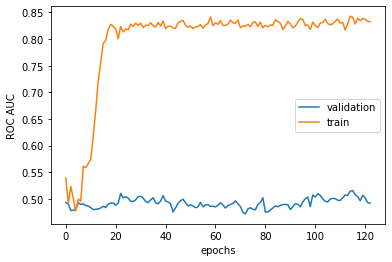

0.49200907349586487
0.4890597442680776


In [9]:
x_input = Input(shape=train_pos_matrix.shape[1])
x_output = Embedding(input_dim = num_pos,
                    output_dim = 8)(x_input)
x_output = Bidirectional(LSTM(25, return_sequences = True))(x_output)
x_output = Bidirectional(LSTM(25))(x_output)
x_output = Dropout(0.3)(x_output)
x_output = Dense(50,activation='relu')(x_output)
x_output = Dropout(0.3)(x_output)
x_output = Dense(20,activation = 'relu')(x_output) 
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 50
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_pos_matrix,y_train,
                             validation_data = (val_pos_matrix,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 1)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_pos_matrix,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

In [ ]:
x_input = Input(shape=train_reduced_pos_matrix.shape[1])
x_output = Embedding(input_dim = num_reduced_pos,
                    output_dim = 8)(x_input)
x_output = Bidirectional(LSTM(25, return_sequences = True),input_shape=input_shape)(x_output)
x_output = Bidirectional(LSTM(25))(x_output)
x_output = Dropout(0.3)(x_output)
x_output = Dense(50,activation='relu')(x_output)
x_output = Dropout(0.3)(x_output)
x_output = Dense(20,activation = 'relu')(x_output) 
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 50
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_reduced_pos_matrix,y_train,
                             validation_data = (val_reduced_pos_matrix,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 0)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_reduced_pos_matrix,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

### X Y input

In [ ]:
#x_train_inputs = x_train_all[:,:,-2]
#y_train_inputs = x_train_all[:,:,-1]
train_inputs   = x_train_all[:,:,[-2,-1]]
val_inputs     = train_inputs[val_idx]
train_inputs   = train_inputs[train_idx]
#x_test_inputs  = x_test_all[:,:,-2]
#y_test_inputs  = x_test_all[:,:,-2]
test_inputs    = x_test_all[:,:,[-2,-1]]

x_input = Input(shape=(train_inputs.shape[1],train_inputs.shape[2]))
x_avg = GlobalAveragePooling1D()(x_input)
x_max = GlobalMaxPool1D()(x_input)
x_output = Concatenate()([x_avg,x_max])
#x_output = Dense(256,activation='relu')(x_output)
#x_output = Dense(128,activation='relu')(x_output)
#x_output = Dropout(0.2)(x_output)
#x_output = Dense(64,activation='relu')(x_output)
#x_output = Dense(32,activation='relu')(x_output)
#x_output = Dense(16,activation='relu')(x_output)
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 50
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_inputs,y_train,
                             validation_data = (val_inputs,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 0)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_inputs,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

In [ ]:
#x_train_inputs = x_train_all[:,:,-2]
#y_train_inputs = x_train_all[:,:,-1]
train_inputs   = x_train_all[:,:,[-2,-1]]
val_inputs     = train_inputs[val_idx]
train_inputs   = train_inputs[train_idx]
#x_test_inputs  = x_test_all[:,:,-2]
#y_test_inputs  = x_test_all[:,:,-2]
test_inputs    = x_test_all[:,:,[-2,-1]]

x_input = Input(shape=(train_inputs.shape[1],train_inputs.shape[2]))
x = Conv1D(32, 4, activation='gelu')(x_input)
x = AveragePooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Conv1D(64, 2, activation='gelu')(x)
x = AveragePooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
#x = Conv1D(64, 4, activation='gelu')(x)
#x = AveragePooling1D(pool_size=2)(x)
#x = BatchNormalization()(x)
#x = Flatten()(x)
x = GlobalAveragePooling1D()(x)
#x = Dense(1024,activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32,activation='relu')(x)
x_output = Dense(1,activation='sigmoid')(x)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 5000
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_inputs,y_train,
                             validation_data = (val_inputs,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 0)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_inputs,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

## POS 1DCNN

In [ ]:
x_input = Input(shape=train_pos_matrix.shape[1])
x_emb = Embedding(input_dim = num_pos,
                    output_dim = 32)(x_input)
x = Conv1D(64, 3, activation='gelu')(x_emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x_avg = GlobalAveragePooling1D()(x_emb)
concat = Concatenate()([x,x_avg])
x_output = Dense(32,activation='relu')(concat)
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 50
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_pos_matrix,y_train,
                             validation_data = (val_pos_matrix,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 0)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_pos_matrix,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

## Entity input

In [ ]:
x_input = Input(shape=train_ent_matrix.shape[1])
x_output = Embedding(input_dim = num_ent,
                    output_dim = 64)(x_input)
x_avg = GlobalAveragePooling1D()(x_output)
x_max = GlobalMaxPool1D()(x_output)
x_output = Concatenate()([x_avg,x_max])
#x_output = Dense(256,activation='relu')(x_output)
#x_output = Dense(128,activation='relu')(x_output)
x_output = Dense(64,activation='relu')(x_output)
x_output = Dense(32,activation='relu')(x_output)
x_output = Dense(16,activation='relu')(x_output)
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

patience = 50
batch_size = 256
epochs = 1000

callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
history = model.fit(train_ent_matrix,y_train,
                             validation_data = (val_ent_matrix,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             verbose = 0)

plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

print(history.history['val_auroc'][-1])

print(history.history['val_auroc'][-1])

y_pred = model.predict(test_ent_matrix,
                       batch_size = batch_size)

fpr, tpr, _ = metrics.roc_curve(
    y_test,
    y_pred,
    pos_label=1,
)
auc = metrics.auc(fpr, tpr)
print(auc)

## RF Input

In [ ]:
x_train_scaled.shape

In [ ]:
drop_out_rates = [0.1,0.2,0.3,0.4,0.5]
for drop_outs in drop_out_rates:
    x_input = Input(shape=num_features)
    x_num = Dense(256,activation='relu')(x_input)
    x_num = Dropout(drop_outs)(x_num)
    x_num = Dense(128,activation='relu')(x_num)
    x_num = Dropout(drop_outs)(x_num)
    x_num = Dense(64,activation='relu')(x_num)
    x_num = Dropout(drop_outs)(x_num)
    x_num = Dense(32,activation='relu')(x_num)
    x_output = Dense(1,activation='sigmoid')(x_num)
    model = Model(inputs=x_input, outputs=x_output)
    opt = Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
    model.summary()

    patience = 50
    batch_size = 256
    epochs = 1000

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)
    x_test_scaled = scaler.transform(x_test)


    callbacks = [EarlyStopping(monitor='val_auroc', patience=patience)]
    history = model.fit(x_train_scaled,y_train,
                                 validation_data = (x_val_scaled,y_val),
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 callbacks = callbacks,
                                 verbose = 0)

    plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
    plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
    plt.xlabel('epochs')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.show()

    print(history.history['val_auroc'][-1])

    y_pred = model.predict(x_test_scaled,
                           batch_size = batch_size)

    fpr, tpr, _ = metrics.roc_curve(
        y_test,
        y_pred,
        pos_label=1,
    )
    auc = metrics.auc(fpr, tpr)
    print(auc)

In [ ]:
pd.DataFrame(x_train.flatten()).describe()

In [ ]:
sns.distplot(x_train.flatten())

In [ ]:
print(history.history['val_auroc'][-1])

In [ ]:
history.history.keys()

In [ ]:
x_input = Input(shape=train_ent_matrix.shape[1])
x_output = Embedding(input_dim = max_pos_len,
                    output_dim = 64)(x_input)
x_output = Dense(32,activation='relu')(x_output)
x_output = GlobalAveragePooling1D()(x_output)
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])
model.summary()

In [ ]:
patience = 10
batch_size = 32
epochs = 100

callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
history = model.fit(train_ent_matrix,y_train,
                             validation_data = (val_ent_matrix,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks)

In [ ]:
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [ ]:
x_input = Input(shape=x_train.shape[1])
x_output = Dense(256,activation='relu')(x_input)
x_output = Dense(128,activation='relu')(x_output)
x_output = Dense(64,activation='relu')(x_output)
x_output = Dense(1,activation='sigmoid')(x_output)
model = Model(inputs=x_input, outputs=x_output)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', auroc])

In [ ]:
model.summary()

In [ ]:
patience = 10
batch_size = 32
epochs = 100

callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
history = model.fit(x_train,y_train,
                             validation_data = (x_val,y_val),
                             batch_size = batch_size,
                             epochs = epochs,
                             callbacks = callbacks)

In [ ]:
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['val_auroc'],label='validation')
plt.plot(np.arange(len(history.history['val_auroc'])),history.history['auroc'],label='train')
plt.xlabel('epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [ ]:
x_train.shape

In [ ]:
np.unique(y_train,return_counts = True)